# Assignment 1

Jonathan McEntee - September 9th 2018

In [14]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
abalone_data = pd.read_csv('abalone.csv')

In [3]:
def convert_to_age_categories(num_rings):
    if num_rings < 9:
        return "Young"
    elif num_rings < 11:
        return "Middle-Aged"
    else:
        return "Old"
    
age_categories = abalone_data.rings.apply(convert_to_age_categories)
abalone_data = abalone_data.assign(age_category = age_categories)
abalone_data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age_category
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,Old
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,Young
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,Middle-Aged
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,Middle-Aged
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,Young


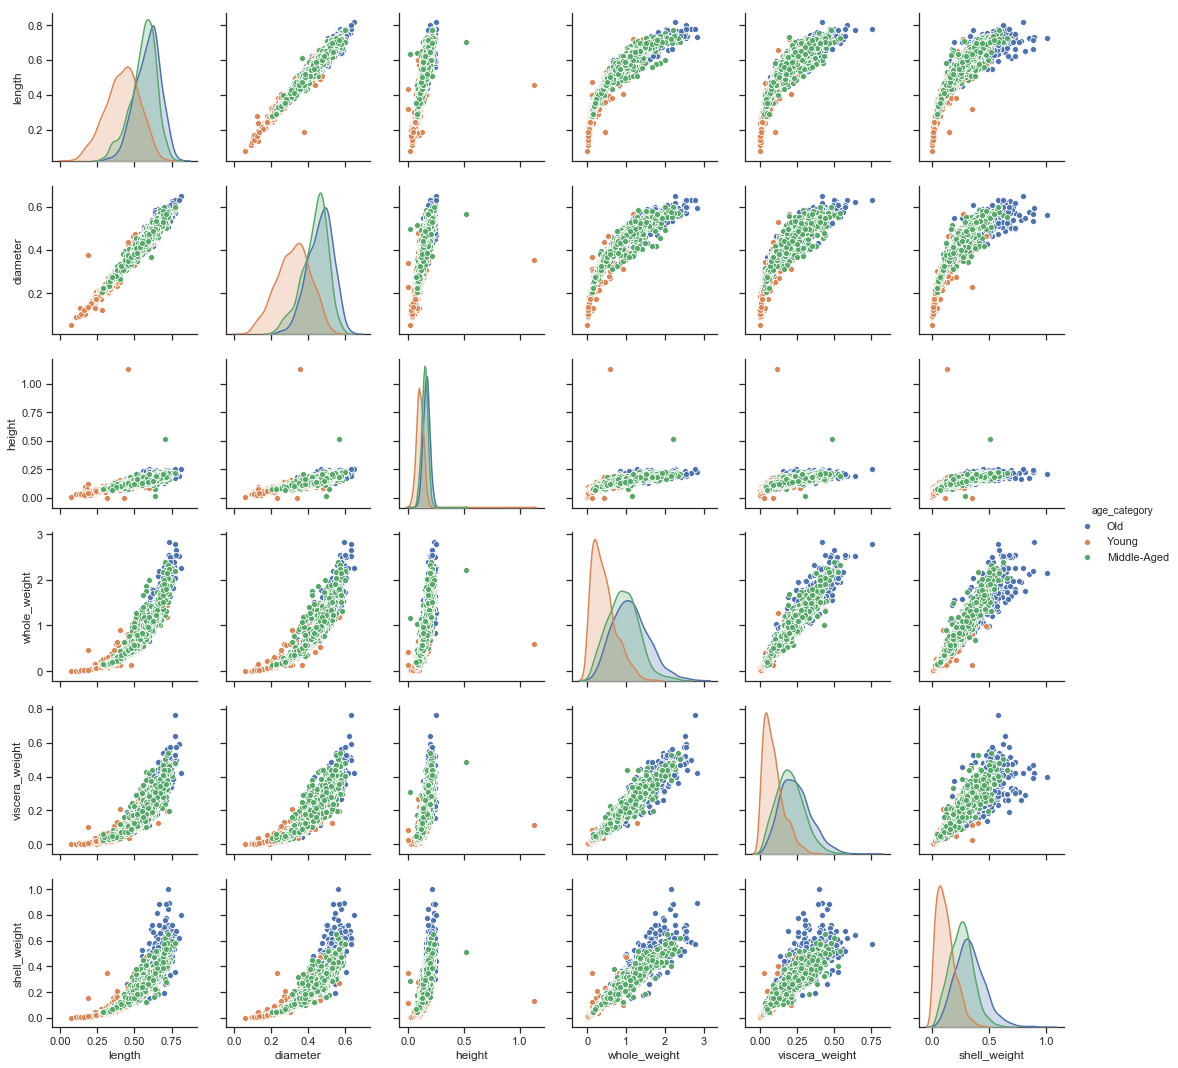

In [4]:
sns.set(style='ticks')
data_to_pairplot = abalone_data.drop(['rings', 'shucked_weight'], axis=1)
sns.pairplot(data_to_pairplot, hue='age_category')

In [5]:
abalone_data.age_category.value_counts()

Old            1447
Young          1407
Middle-Aged    1323
Name: age_category, dtype: int64

Lets make a training and a test set

In [6]:
abalone_data = abalone_data.assign(**pd.get_dummies(abalone_data.sex)).drop(['sex', 'rings'], axis=1)

In [7]:
y = abalone_data['age_category']
X = abalone_data.drop(['age_category'], axis=1)

y_train, y_test = train_test_split(y, test_size=0.1, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Functions

In [9]:
def learning_curve_dataframe(X, y, clf):
    score_type = []
    scores = []
    no_samples = []

    for test_size in np.arange(0.05, 0.95, 0.01):
        X_cv_train, X_cv_test = train_test_split(X, test_size=test_size, random_state=42)
        y_cv_train, y_cv_test = train_test_split(y, test_size=test_size, random_state=42)

        clf.fit(X=X_cv_train, y=y_cv_train)

        for _ in range(2): no_samples.append(len(X_cv_train))

        score_type.append('training')
        scores.append(clf.score(X=X_cv_train, y=y_cv_train))

        score_type.append('test')
        scores.append(clf.score(X=X_cv_test, y=y_cv_test))

    return pd.DataFrame(dict(no_samples=no_samples, score=scores, score_type=score_type))
    
def feature_growth_data(clf, variable, parameter_range):
    """ Compares training and cross-validation accuracy over a changing hyperparameter.
    
    Parameters:
        clf: the classifier
        fixed: a dictionary of fixed parameters
        variable: a string naming the parameter to be varied
        parameter_range: the values (generally a numeric range) to vary over
    """
    no_samples = []
    scores = []
    score_type = []

    for parameter_value in parameter_range:
        parameter = {variable : parameter_value}
        clf = clf.set_params(**parameter)
        clf.fit(X=X_train, y=y_train)

        for _ in range(2): no_samples.append(parameter_value)

        score_type.append('training')
        scores.append(clf.score(X=X_train, y=y_train))

        score_type.append('cross validation')
        scores.append(cross_val_score(clf, X=X_train, y=y_train, cv=10).mean())
        
    return pd.DataFrame(dict(no_samples=no_samples, score=scores, score_type=score_type))

def plot_scores(title, score_data, xlabel=None, ylabel=None):
    fig = plt.figure()
    fig.suptitle(title)
    
    sns.set_style("whitegrid")
    plt.ylim(ymin=0)
    curves = sns.lineplot(x='no_samples', y='score', hue='score_type', data=score_data)
    
    if xlabel is not None:
        curves.set(xlabel=xlabel)
    
    if ylabel is not None:
        curves.set(ylabel=ylabel)
    
    sns.despine(left=True)

## Using a Decision Tree Classifier

First we'll find the best parameters with a grid search

In [ ]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

The best parameters appear to be min_samples_split=400 and max_depth=7

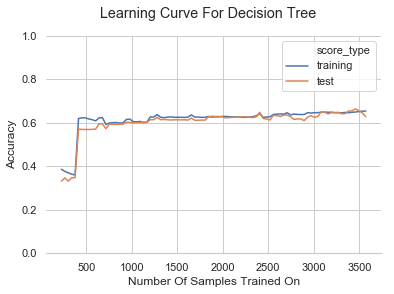

In [10]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_split=400)
learning_curve_data = learning_curve_dataframe(X=X_train, y=y_train, clf=clf)

plot_scores(title="Learning Curve For Decision Tree",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

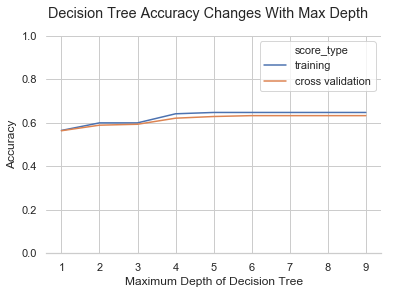

In [13]:
decision_tree = DecisionTreeClassifier(min_samples_split=420)
accuracy_vs_depth = feature_growth_data(clf=decision_tree, variable='max_depth', parameter_range=range(1, 10))

plot_scores(title="Decision Tree Accuracy Changes With Max Depth",
            xlabel="Maximum Depth of Decision Tree",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

## Using K Nearest Neighbors

In [15]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 28, 'p': 2, 'weights': 'distance'}

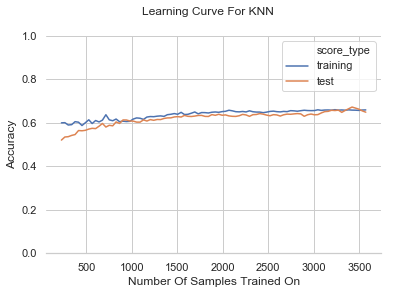

In [25]:
clf = KNeighborsClassifier(p=2, n_neighbors=50)
learning_curve_data = learning_curve_dataframe(X=X_train, y=y_train, clf=clf)

plot_scores(title="Learning Curve For KNN",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

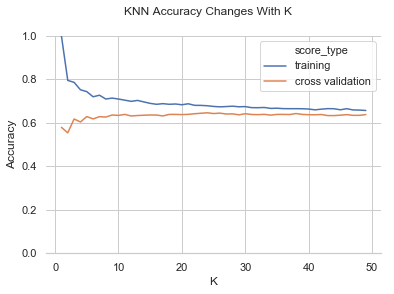

In [24]:
clf = KNeighborsClassifier(p=2)
accuracy_vs_depth = feature_growth_data(clf=clf, variable='n_neighbors', parameter_range=range(1, 50))

plot_scores(title="KNN Accuracy Changes With K",
            xlabel="K",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)